### Do your imports!

In [1]:
import pandas as pd
import numpy as py
pd.set_option("display.max_rows", 200)

/Users/richardabbey/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# 311 data analysis

## Read in `subset.csv` and review the first few rows

Even though it's a giant file – gigs and gigs! – it's a subset of the [entire dataset](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9). It covers plenty of years, but not all of the columns.

If your computer is struggling (which it will!) or you are impatient, feel free to use `nrows=` when reading it in to speed up the process by only reading in a subset of columns. Pull in at least a few million, or a couple years back.

In [2]:
#Deciding to review the first 10 million rows means I will choose 

df = pd.read_csv('subset.csv', nrows=10000000)


/Users/richardabbey/.pyenv/versions/3.9.7/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.shape

(10000000, 15)

### Where the subset came from

If you're curious, I took the [original data](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/data) and clipped out a subset by using the command-line tool [csvkit](https://csvkit.readthedocs.io/en/latest/).

First I inspected the column headers:

```bash
$ csvcut -n 311_Service_Requests_from_2010_to_Present.csv 
```

Then I selected the columns I was interested in and saved it to a file.

```bash
$ csvcut -c 1,2,3,4,5,6,7,8,9,10,16,17,20,26,29 311_Service_Requests_from_2010_to_Present.csv > subset.csv
```

This was much much much much faster than doing it in Python.

## We want more columns!

**Right now we don't see all of the columns.** For example, mine has `...` between the **Incident Address** column and the **City** column. Go up to the top where you imported pandas, and add a `pd.set_option` line that will allow you to view all of the columns of the dataset.

In [88]:
#Here, I decided to replace all the spaces in the names of the columns with underscores to make it for easier handling
df.columns = df.columns.str.lower().str.replace(" ", "_")

## We hate those column names!

Change the column names to be tab- and period-friendly, like `df.created_date` instead of `df['Created Date']`

In [ ]:
###

# Dates and times

## Are the datetimes actually datetimes?

We're going to be doing some datetime-y things, so let's see if the columns that look like dates are actually dates.

In [5]:
#df.info() brings out the data and Data type of each column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 15 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   unique_key              int64 
 1   created_date            object
 2   closed_date             object
 3   agency                  object
 4   agency_name             object
 5   complaint_type          object
 6   descriptor              object
 7   location_type           object
 8   incident_zip            object
 9   incident_address        object
 10  address_type            object
 11  city                    object
 12  status                  object
 13  borough                 object
 14  open_data_channel_type  object
dtypes: int64(1), object(14)
memory usage: 1.1+ GB


## In they aren't datetimes, convert them

The ones we're interested in are as follows:

* Created Date
* Closed Date

You have two options to convert them:

1. Do it like we did in class, but **overwrite the existing string columns with the new datetime versions**
2. Find an option with `read_csv` to automatically read certain columns as dates! Use the shift+tab trick to read the `read_csv` docs to uncover it. Once you find it, you'll set it to be the **list of date-y columns**.

They're both going to take forever if you do them wrong, but can be faster with a few tricks. For example, using `pd.to_datetime` can be sped up significantly be specifying the format of the datestring.

For example, if your datetime was formatted as `YYYY-MM-DD HH:MM:SS AM`, you could use the following:

```
df.my_datetime = pd.to_datetime(df.my_datetime, format="%Y-%m-%d %I:%M:%S %p")
```

It's unfortunately much much much faster than the `read_csv` technique. And yes, [that's `%I` and not `%H`](https://strftime.org/).

> *Tip: What should happen if it encounters an error or missing data?*

In [89]:
#Looking at the format of date in the dataframe, I use same format from datetime
#to convert it from from object to datetime data type

df.created_date = pd.to_datetime(df.created_date, errors='coerce', format="%m/%d/%Y %I:%M:%S %p")

In [7]:
#Looking at the format of date in the dataframe, I use same format from datetime
#to convert it from from object to datetime data type
df.closed_date = pd.to_datetime(df.closed_date, errors='coerce', format="%m/%d/%Y %I:%M:%S %p")

## According to the dataset, which month of the year has the most 311 calls?

The kind of answer we're looking for is "January," not "January 2021"

In [91]:
#So, I used strftime to pull out all the months from the data frame. 
#Then I selected the month that shows up more

df.created_date.dt.month

month.value_counts().head(1)

June    989313
Name: created_date, dtype: int64

## According to the dataset, which month has had the most 311 calls?

The kind of answer we're looking for is "January 2021," not "January" (although _techniucally_ it will say `2021-01-31`, not `January 2021`)

In [98]:
#I used strftime('%B %Y') to pull out the month and year. 
#And counted which one appeared most often to determine which month had the most 311 calls

df.created_date.dt.strftime('%B %Y').value_counts().sort_values(ascending=False).head(1)

June 2021    239268
Name: created_date, dtype: int64

## Plot the 311 call frequency over our dataset on a _weekly_ basis

To make your y axis start at zero, use `ylim=(0,100000)` when doing `.plot`. But replace the `1000` with a large enough value to actually see your data nicely!

<AxesSubplot:xlabel='created_date'>

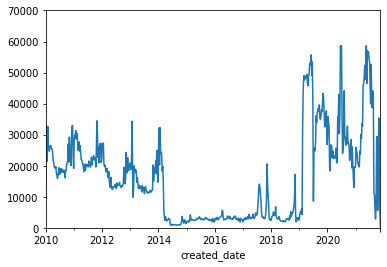

In [109]:
# W = using resample on created date plots the weekly data based on datetime on created date
df.resample('W', on='created_date').size().plot(ylim=[0, 70000])

## What time of day (by hour) is the most least for 311 complains? The most common?


In [119]:
#Essentialy we are looking at what hour is present under the created date column. 
#This would provide the answers to what is the least and common time for 311 complaints
#This cell gives the time for most 311 calls
#The strftime('%I %p') makes the time more specific

df.created_date.dt.strftime('%I %p').value_counts().sort_values(ascending=False).head(1)


0    2874274
Name: created_date, dtype: int64

In [118]:
#This cell gives the least time most 311 calls

df.created_date.dt.strftime('%I %p').value_counts().sort_values(ascending=False).tail(1)

04 AM    57757
Name: created_date, dtype: int64

### Make a graph of the results

* Make sure the hours are in the correct order
* Be sure to set the y-axis to start at 0
* Give your plot a descriptive title

<AxesSubplot:>

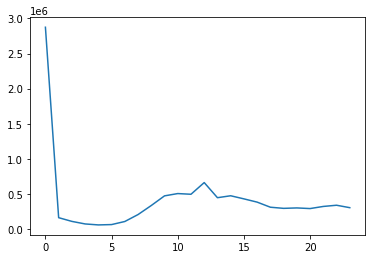

In [161]:
#This plots the hour data pulled from the created_date datetime column and plots it over 24hr cycyle

df.created_date.dt.hour.value_counts().sort_index().plot(x='created_date', y='0')


# .plot(x='created_date', y='0')

# Agencies

## What agencies field the most complaints in the dataset? Get the top 5.

Use the `agency` column for this one.

In [75]:
df.agency.value_counts().head(5)

HPD     3502371
NYPD    2374479
DOT     1095864
DSNY     980011
DOB      589089
Name: agency, dtype: int64

## What are each of those agencies?

Define the following five acronyms:

* NYPD
* HPD
* DOT
* DSNY
* DEP

In [16]:
# NYPD = New York Police Department 
# HPD = Department of Housing Preservation and Development
# DOT = Department of Transportation
# DSNY = New York Department of Sanitation
# DEP = Department of Environmental Protection

## What is the most common complaint to HPD?

In [162]:
#This here we create a dataframe of complaints involving HPD

HPD = df[df.agency_name == "Department of Housing Preservation and Development"]['complaint_type']

HPD.value_counts().head(1)

HEATING    876597
Name: complaint_type, dtype: int64

## What are the top 3 complaints to each agency?

You'll want to use the weird confusing `.groupby(level=...` thing we learned when reviewing the homework.

In [74]:
#This groups agencies and look at their complaints types and narrow to top three using the index

df.groupby(['agency'])['complaint_type'].agg(lambda x:x.value_counts().index[0:3])


agency
3-1-1                                      [Noise Survey, OEM Disabled Vehicle, Benefit C...
ACS                                                                    [Forms, Damaged Tree]
COIB                                                                                   Forms
DCA                                        [Consumer Complaint, DCA / DOH New License App...
DCAS                                                                    [Question, Comments]
DCP                                                                       Research Questions
DEP                                                             [Water System, Noise, Sewer]
DFTA                                       [Housing - Low Income Senior, Elder Abuse, Hom...
DHS                                        [Homeless Person Assistance, DHS Advantage - T...
DOB                                        [General Construction/Plumbing, Building/Use, ...
DOE                                        [School Maintenance,

## What is the most common kind of residential noise complaint?

The NYPD seems to deal with a lot of noise complaints at homes. What is the most common subtype?

In [163]:
#For ease of reference, I create a dataframe looking at 'Noise - Residential' complaint types
#Then I look at the descriptions of complaint type
res_noise = df[df.complaint_type == 'Noise - Residential']

res_noise.descriptor.value_counts().head(1)

Loud Music/Party    492413
Name: descriptor, dtype: int64

## What time of day do "Loud Music/Party" complaints come in? Make it a chart!

In [165]:
# I stick to res_noise dataframe. And I used my datetime function 
#to extract the hours from created_date in res_noise dataframe and value_count it.


res_noise[res_noise['descriptor'] == "Loud Music/Party"].created_date.dt.hour.value_counts()

23    64803
22    59414
0     56693
21    42124
1     40265
20    32312
19    25560
2     25406
18    20208
17    16718
3     15976
16    14056
15    11648
14    10100
4      9700
13     9011
12     7359
5      6042
11     5701
10     4688
9      3979
6      3926
7      3363
8      3361
Name: created_date, dtype: int64

In [166]:
res_noise[res_noise['descriptor'] == "Loud Music/Party"].created_date.dt.hour.value_counts()

23    64803
22    59414
0     56693
21    42124
1     40265
20    32312
19    25560
2     25406
18    20208
17    16718
3     15976
16    14056
15    11648
14    10100
4      9700
13     9011
12     7359
5      6042
11     5701
10     4688
9      3979
6      3926
7      3363
8      3361
Name: created_date, dtype: int64

<AxesSubplot:>

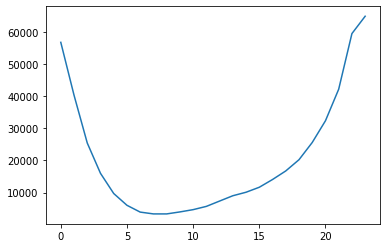

In [168]:
#This plot the time of data showing when most loud music/party complaints are recorded

loud_music = res_noise[res_noise['descriptor'] == "Loud Music/Party"]

loud_music.created_date.dt.hour.value_counts().sort_index().plot()

## When do people party hard?

Make a monthly chart of Loud Music/Party complaints since the beginning of the dataset. Make it count them on a biweekly basis (every two weeks).

In [23]:
#Using the dataframe for loud music created, I extract the months and value_count them.

loud_music.created_date.dt.month.value_counts()


6     69568
7     65769
5     62101
8     56805
9     41344
4     39779
10    38938
3     29221
11    26225
1     22693
2     20199
12    19771
Name: created_date, dtype: int64

<AxesSubplot:xlabel='created_date'>

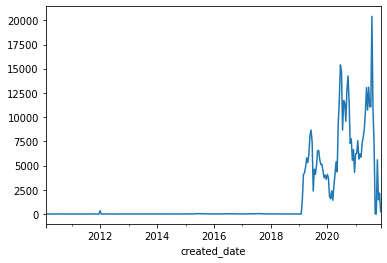

In [169]:
#I used my dataframe loud_music resample to plot my data to show biweekly count of Loud Music/Party complaints 

loud_music.resample('2W', on='created_date').size().plot()

## People and their bees

Sometimes people complain about bees! Why they'd do that, I have no idea. It's somewhere in "complaint_type" – can you find all of the bee-related complaints?

In [170]:
#I first use .str.contains to search where there are bees. 
#Then I create a dataframe using the Harboring Bees/Wasps complaint type.

bees = df[df.complaint_type == 'Harboring Bees/Wasps']


bees

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,address_type,city,status,borough,open_data_channel_type,time_to_fix
288065,42054326,2019-03-26 19:10:34,2019-04-05 15:00:55,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Beekeeping - Honeybees,1-2 Family Dwelling,11103.0,24-19 42 STREET,ADDRESS,ASTORIA,Closed,QUEENS,PHONE,9 days 19:50:21
291446,42058804,2019-03-26 18:14:03,2019-04-05 15:02:00,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Beekeeping - Honeybees,1-2 Family Dwelling,11104.0,42-19 42 STREET,ADDRESS,SUNNYSIDE,Closed,QUEENS,PHONE,9 days 20:47:57
372834,42163934,2019-04-08 18:26:04,2019-04-29 11:18:17,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Bees/Wasps - Not a beekeper,1-2 Family Dwelling,10302,57 HOOKER PLACE,ADDRESS,STATEN ISLAND,Closed,STATEN ISLAND,PHONE,20 days 16:52:13
378505,42171504,2019-04-08 15:50:40,2019-04-29 11:11:42,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Bees/Wasps - Not a beekeper,1-2 Family Mixed Use Building,11214,2060 78 STREET,ADDRESS,BROOKLYN,Closed,BROOKLYN,ONLINE,20 days 19:21:02
391645,42189666,2019-04-10 19:28:14,2019-04-29 11:17:09,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Beekeeping - Honeybees,1-2 Family Dwelling,10469,1462 STICKNEY PLACE,ADDRESS,BRONX,Closed,BRONX,PHONE,18 days 15:48:55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9942274,43389401,2019-07-26 11:08:29,NaT,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Bees/Wasps - Not a beekeper,1-2 Family Dwelling,10310.0,104 ELIZABETH STREET,NaN,STATEN ISLAND,In Progress,STATEN ISLAND,PHONE,NaT
9959523,46376328,2020-06-03 20:32:14,NaT,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Bees/Wasps - Not a beekeper,1-2 Family Dwelling,11434.0,137-18 160 STREET,NaN,JAMAICA,In Progress,QUEENS,PHONE,NaT
9993700,51340804,2021-07-26 10:01:15,NaT,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Bees/Wasps - Not a beekeper,1-2 Family Dwelling,10314.0,342 GANSEVOORT BOULEVARD,NaN,STATEN ISLAND,In Progress,STATEN ISLAND,PHONE,NaT
9994578,51342433,2021-07-26 10:51:10,NaT,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Bees/Wasps - Not a beekeper,3+ Family Apartment Building,11214.0,21 BAY 14 STREET,NaN,BROOKLYN,In Progress,BROOKLYN,ONLINE,NaT


### What month do most of the complaints happen in? I'd like to see a graph.

In [177]:
#From the bees dataframe, I esxtract the month from the created_date column.
#I look out for the month most complaints came in

bees.created_date.dt.month.value_counts()

5     100
8      83
9      70
7      54
4      35
6      33
10     32
11      8
3       3
12      2
1       2
Name: created_date, dtype: int64

<AxesSubplot:>

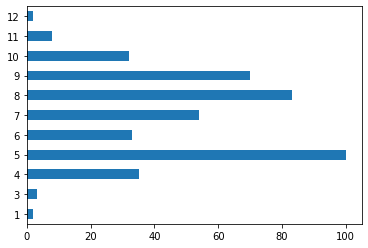

In [173]:
#I extract the monthly data from the created dat

bees.created_date.dt.month.value_counts().sort_index().plot(kind='barh')

### Are the people getting in trouble usually beekeepers or not beekeepers?

In [175]:
#I extract the descriptor to find out those involved in the complaints about bees

bees['descriptor'].value_counts()

Bees/Wasps - Not a beekeper    359
Beekeeping - Honeybees          63
Name: descriptor, dtype: int64

# Math with datetimes

## How long does it normally take to resolve a 311 complaint?

Even if we didn't cover this in class, I have faith that you can guess how to calculate it.

In [176]:
#To find out how long resolution takes, 
#I create a column that substracts created date from closed date.

df['time_to_fix'] = df['closed_date'] - df['created_date']

Save it as a new column called `time_to_fix`

In [28]:
df.time_to_fix

0         16 days 15:27:04
1         14 days 15:00:26
2         29 days 21:26:32
3          6 days 14:38:16
4          6 days 16:18:23
                ...       
9999995    0 days 07:13:39
9999996   25 days 23:55:09
9999997    0 days 02:56:59
9999998    4 days 01:47:26
9999999    0 days 03:55:53
Name: time_to_fix, Length: 10000000, dtype: timedelta64[ns]

## Which agency has the best time-to-fix time?

In [178]:
# I group complaints by agencies and extract and look at the median of their to time to fix

df.groupby(by='agency').time_to_fix.median().head(1)

agency
3-1-1   0 days 00:00:39
Name: time_to_fix, dtype: timedelta64[ns]

## Maybe we need some more information...

I might want to know how big our sample size is for each of those, maybe the high performers only have one or two instances of having requests filed!

### First, try using `.describe()` on the time to fix column after your `groupby`.

In [30]:
#Using .describe to extract all the descriptive stats of the data

df.groupby(by='agency').time_to_fix.describe()

,count,mean,std,min,25%,50%,75%,max
agency,,,,,,,,
3-1-1,65,0 days 00:00:56.984615384,0 days 00:01:17.965034692,0 days 00:00:03,0 days 00:00:17,0 days 00:00:39,0 days 00:00:58,0 days 00:07:44
ACS,1,0 days 22:48:06,NaT,0 days 22:48:06,0 days 22:48:06,0 days 22:48:06,0 days 22:48:06,0 days 22:48:06
COIB,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
DCA,60272,32 days 04:31:21.617367932,103 days 02:16:16.679270175,0 days 00:04:02,0 days 21:25:45,1 days 16:28:18,3 days 02:23:07.500000,804 days 21:18:42
DCAS,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
DCP,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
DEP,416232,8 days 22:47:54.406532895,66 days 22:29:02.667316639,-1829 days +15:05:00,0 days 02:35:00,0 days 21:53:00,3 days 23:23:15,4033 days 23:51:00
DFTA,5244,9 days 10:19:09.692791762,22 days 16:47:45.060063388,0 days 00:01:30,2 days 14:57:11.500000,8 days 22:34:12,13 days 20:23:50.500000,1506 days 10:19:19
DHS,133609,3 days 19:55:59.929503252,11 days 08:08:49.044888541,0 days 00:00:04,0 days 02:01:07,1 days 00:20:02,5 days 00:29:20,586 days 12:35:49


### Now, an alternative

Seems a little busy, yeah? **You can also do smaller, custom aggregations.**

Try something like this:

```python
# Multiple aggregations of one column
df.groupby('agency').time_to_fix.agg(['median', 'size'])

# You can also do something like this to reach multiple columns
df.groupby('agency').agg({
    'time_to_fix': ['median', 'size']
})
```

In [31]:
df.groupby('agency').agg({
    'time_to_fix': ['median', 'size']
})

time_to_fix         
                                                         median     size
agency                                                                  
3-1-1                                           0 days 00:00:39       67
ACS                                                         NaT      136
COIB                                                        NaT        4
DCA                                             1 days 16:17:32    60431
DCAS                                                        NaT      281
DCP                                                         NaT        9
DEP                                             0 days 21:17:00   421716
DFTA                                            8 days 22:28:24     5245
DHS                                             1 days 00:14:49   134062
DOB                                             9 days 04:16:32   589089
DOE                                             5 days 00:20:27     2406
DOF                                             2 days 04:57:07   242535
DOHMH                                           0 days 00:00:00   123966
DOITT                                   15 days 00:55:14.500000      696
DORIS                                    1 days 00:04:02.500000       58
DOT                                      0 days 19:53:23.500000  1095864
DPR                                      2 days 21:59:49.500000   269764
DSNY                                            1 days 16:21:00   980011
DVS                                                         NaT      120
EDC                                             0 days 00:00:03    21929
FDNY                                                        NaT       13
HPD                                             5 days 16:57:46  3502371
HRA                                             0 days 00:00:38    69512
MAYORâS OFFICE OF SPECIAL ENFORCEMENT  0 days 06:11:54.500000    47392
NYCEM                                          12 days 22:18:37     4267
NYPD                                            0 days 00:55:54  2374479
TAX                                                         NaT       87
TLC                                             1 days 11:51:23    53490

## Seems weird that NYPD time-to-close is so fast. Can we break that down by complaint type?

Remember the order: 

1. Filter
2. Group
3. Grab a column
4. Do something with it
5. Sort

In [180]:
#Looked at the dataframe for the NYPD complaints

NYPD = df[df.agency == "NYPD"]

NYPD.complaint_type.value_counts().sort_values(ascending=False).head()


Noise - Residential        706826
Illegal Parking            473055
Noise - Street/Sidewalk    361498
Blocked Driveway           271172
Noise - Vehicle            148490
Name: complaint_type, dtype: int64

## Back to median fix time for all agencies: do these values change based on the borough?

First, use `groupby` to get the median time to fix per agency in each borough. You can use something like `pd.set_option("display.max_rows", 200)` if you can't see all of the results by default!

In [193]:
df.groupby(by='borough').time_to_fix.median()

borough
BRONX           1 days 20:19:28
BROOKLYN        1 days 13:22:52
MANHATTAN       1 days 00:00:00
QUEENS          0 days 20:47:17
STATEN ISLAND   1 days 03:39:00
Unspecified     5 days 00:00:00
Name: time_to_fix, dtype: timedelta64[ns]

### Or, use another technique!

We talked about pivot table for a hot second in class, but it's (potentially) a good fit for this situation:

```python
df.pivot_table(
    columns='what will show up as your columns',
    index='what will show up as your rows',
    values='the column that will show up in each cell',
    aggfunc='the calculation(s) you want dont'
)
```

### Use the pivot table result to find the worst-performing agency in the Bronx, then compare with Staten Island

Since it's a dataframe, you can use the power of `.sort_values` (twice!). Do any of the agencies have a large difference between the two?

In [194]:
df.pivot_table(
    columns='borough',
    index='agency',
    values='time_to_fix',
    aggfunc='median',
).sort_values(by='BRONX')


borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Unspecified
agency,,,,,,
DOHMH,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,NaT
NYPD,0 days 01:15:17,0 days 00:51:49,0 days 00:38:02,0 days 01:11:41,0 days 00:44:02,0 days 04:33:00
MAYORâS OFFICE OF SPECIAL ENFORCEMENT,0 days 05:34:18.500000,0 days 06:40:13.500000,0 days 05:23:25,0 days 13:23:38,1 days 09:32:46.500000,0 days 15:28:30
DOT,0 days 05:55:18.500000,0 days 19:03:43,1 days 00:22:37,0 days 19:55:57,1 days 02:47:04,1 days 15:30:33
DEP,0 days 17:54:00,0 days 17:00:00,1 days 09:49:00,0 days 18:15:00,0 days 17:37:00,0 days 00:05:00
DSNY,1 days 02:59:00,1 days 19:27:00,1 days 18:08:00,1 days 11:20:00,1 days 23:16:00,1 days 21:15:00
DCA,1 days 06:34:40,1 days 14:19:33,1 days 15:20:04,1 days 17:21:59,1 days 15:08:57,1 days 18:02:44
DOF,2 days 06:22:35,2 days 02:06:29,2 days 02:45:30,2 days 02:10:58,2 days 02:56:04,2 days 22:15:23.500000
DHS,3 days 02:49:00,1 days 09:54:05,0 days 02:11:33,1 days 03:51:57,3 days 04:10:10,0 days 03:06:14


## What were the top ten 311 types of complaints on Thanksgiving 2020? Are they different than the day before Thanksgiving?

**Finding exact dates is awful, honestly.** While you can do something like this to ask for rows after a specific date:

```python
df[df.date_column >= '2020-01-01']
```

You, for some reason, can't ask for an **exact match** unless you're really looking for exactly at midnight. For example, this won't give you what you want:

```python
df[df.date_column == '2020-01-01']
```

Instead, the thing you need to do is this:

```python
df[(df.date_column >= '2020-01-01') & (df.date_column < '2020-01-02']
```

Everything that starts at midnight on the 1st but *is still less than midnight on the 2nd**.

In [68]:
#I look at two days between Thanksgiving of 2020 and looked at the complaints types recorded
#on those days. And looked at the top 10.

thanks_giving = df[(df.created_date >= '2020-11-26') & (df.created_date < '2020-11-27')].complaint_type.value_counts()


thanks_giving.head(10)

Noise - Residential                    766
Illegal Parking                        324
Noise - Street/Sidewalk                218
Blocked Driveway                       190
Noise - Vehicle                        150
HEAT/HOT WATER                         135
NonCompliance with Phased Reopening     52
Homeless Person Assistance              46
Noise - Commercial                      38
Rodent                                  22
Name: complaint_type, dtype: int64

## What is the most common 311 complaint types on Christmas day?

And I mean *all Christmas days*, not just in certain years)

* Tip: `dt.` and `&` are going to be your friend here
* Tip: If you want to get fancy you can look up `strftime`
* Tip: One of those is much much faster than the other

In [72]:
#Similarly, this looked at the complaint types recorded on X'mas day.


X_mas = df[(df.created_date >= '2020-12-25') & (df.created_date < '2020-12-26')].complaint_type.value_counts()

X_mas.head(10)

Noise - Residential                    829
Illegal Parking                        322
Blocked Driveway                       256
HEAT/HOT WATER                         244
Damaged Tree                           142
Noise - Vehicle                         85
Noise - Street/Sidewalk                 85
Noise - Commercial                      34
NonCompliance with Phased Reopening     29
General Construction/Plumbing           28
Name: complaint_type, dtype: int64

# Stories

Let's approach this from the idea of **having stories and wanting to investigate them.** Fun facts:

* Not all of these are reasonably answered with what our data is
* We only have certain skills about how to analyzing the data
* There are about six hundred approaches for each question

But: **for most of these prompts there are at least a few ways you can get something interesting out of the dataset.**

## Fireworks and BLM

You're writing a story about the anecdotal idea that the summer of the BLM protests there were an incredible number of fireworks being set off. Does the data support this?

What assumptions is your analysis making? What could make your analysis fall apart?

In [85]:
#Here, I am looking at complaints about fireworks and they were mostly reported to the NYPD. 
#BLM protests according to wikipedia peaked around June 2020, so the assumption would be that whatever surge in fireworks
#would be in that summer. I am assuming that all illegal fireworks reported between June 1, 2020 and June 6, 2020 
#were in connection with the BLM protests. The analysis could fall apart if the locations of the 
#illegal fireworks were not places were BLM protests were held.


    

Fireworks = df[df.complaint_type == "Illegal Fireworks"]

    
    
    
    
BLM = Fireworks[(Fireworks.created_date >= '2020-06-01') \
                & (Fireworks.created_date < '2020-08-01')].complaint_type.value_counts()

BLM





Illegal Fireworks    41444
Name: complaint_type, dtype: int64

In [87]:
#Same period 2019

same_period = Fireworks[(Fireworks.created_date >= '2019-06-01') \
    & (Fireworks.created_date < '2019-08-01')] \
    .complaint_type.value_counts()

same_period

Illegal Fireworks    209
Name: complaint_type, dtype: int64

## Sanitation and work slowdowns

The Dept of Sanitation recently had a work slowdown to protest the vaccine mandate. You'd like to write about past work slowdowns that have caused garbage to pile up in the street, streets to not be swept, etc, and compare them to the current slowdown. You've also heard rumors that it was worse in Staten Island and a few Brooklyn neighborhoods - Marine Park and Canarsie - than everywhere else.

Use the data to find timeframes worth researching, and note how this slowdown might compare. Also, is there anything behind the geographic issue?

What assumptions is your analysis making? What could make your analysis fall apart?

## Gentrification and whining to the government

It's said that when a neighborhood gentrifies, the people who move in are quick to report things to authorities that would previously have been ignored or dealt with on a personal basis. Use the data to investigate the concept (two techniques for finding gentrifying area are using census data and using Google).

What assumptions is your analysis making? What could make your analysis fall apart? Be sure to cite your sources. 

## 311 quirks

Our editor tried to submit a 311 request using the app the other day, but it didn't go through. As we all know, news is what happens to your editor! Has the 311 mobile app ever actually stopped working?

If that's a dead end, maybe you can talk about the differences between the different submission avenues: could a mobile outage disproportionately impact a certain kind of complaint or agency? How about if the phone lines stopped working?

What assumptions is your analysis making? What could make your analysis fall apart?

## NYCHA and public funds

NYC's public housing infrastructure is failing, and one reason is lack of federal funds. While the recent spending bills passed through Congress might be able to help, the feeling is that things have really fallen apart in the past however-many years – as time goes on it gets more and more difficult for the agency in control of things to address issues in a timely manner.

If you were tasked with finding information to help a reporter writing on this topic, you will **not** reasonably be able to find much in the dataset to support or refute this. Why not? 

If you wanted to squeeze something out of this dataset anyway, what could an option be? (You might need to bring in another dataset.)